In [1]:
#import packages
import pandas as pd
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error
from itertools import product
import re # For cleaning functions

#hyperparameters
SEQ_LEN = 20
BATCH_SIZE = 32
N_EPOCHS = 30 # N_EPOCHS was increased to improve model performance

#seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(13)

# Data Cleaning Functions
def clean_volume(volume_str):
    if isinstance(volume_str, (int, float)):
        return volume_str
    if not isinstance(volume_str, str):
        return np.nan
    volume_str = volume_str.strip().upper()
    if volume_str == '-' or volume_str == '':
        return np.nan
    multipliers = {'K': 10**3, 'M': 10**6, 'B': 10**9}
    if volume_str[-1] in multipliers:
        return float(volume_str[:-1]) * multipliers[volume_str[-1]]
    return float(volume_str)

def clean_change_pct(change_str):
    if isinstance(change_str, (int, float)):
        return change_str
    if not isinstance(change_str, str):
        return np.nan
    change_str = change_str.strip()
    if change_str == '-' or change_str == '':
        return np.nan
    if change_str.endswith('%'):
        return float(change_str[:-1]) / 100.0
    return float(change_str)

In [2]:
#define model, using GRU as it was best in single variate case
class StockGRU3(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size=3):
        super().__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :])

#create sequences aligns all the data
def create_sequences(input_data_scaled, output_data_scaled, seq_len):
    Xs, ys = [], []
    # Ensure input_data_scaled and output_data_scaled have the same length after potential NaN drops from lagging
    # The length check should be (len(input_data_scaled) - seq_len) or similar
    # to prevent indexing errors.
    # Assumes output_data_scaled rows correspond to input_data_scaled rows.
    # Target is at the END of the sequence.
    for i in range(len(input_data_scaled) - seq_len):
        Xs.append(input_data_scaled[i:(i + seq_len)])
        ys.append(output_data_scaled[i + seq_len -1]) # Or i + seq_len if predicting one step truly ahead of sequence end
                                                    # Original likely implies y is the target values at the last step of the sequence's corresponding future time.
                                                    # Let's assume y should be at time t if X is t-seq_len to t-1.
                                                    # So, if X ends at index k, y is at index k+1. data[i+seq_len] is common.
    # If using target_indices for columns within a single scaled array (original approach):
# def create_sequences(all_scaled_data, seq_len, list_of_target_indices_in_all_scaled_data):
#     Xs, ys = [], []
#     for i in range(len(all_scaled_data) - seq_len):
#         Xs.append(all_scaled_data[i:(i + seq_len), :]) # All features for sequence X
#         ys.append(all_scaled_data[i + seq_len, list_of_target_indices_in_all_scaled_data])
#     return np.array(Xs), np.array(ys)
    # Sticking to the original implied structure where y is extracted by index from the main scaled data
    # This means `output_data_scaled` is effectively `all_scaled_data[:, target_indices_for_y]`
    # However, the function signature used later is `create_sequences(scaled_data_for_X_and_Y, SEQ_LEN, target_indices_in_scaled_data)`
    # Let's rename for clarity if it was one array passed in.
    # For now, assuming `input_data_scaled` is for X and `output_data_scaled` is for Y based on good practice separation.
    # The original notebook had create_sequences(scaled, SEQ_LEN, target_indices) where scaled included all columns.
    # So, the commented out version above is likely closer to the original's intent.
    # For this modification, let's assume `create_sequences_from_combined_array` is used if targets are part of the main scaled array.

# This version aligns with how target_indices was used (indices within the features array)
def create_sequences_from_combined_array(all_scaled_data, seq_len, list_of_target_indices):
    Xs, ys = [], []
    # Make sure all_scaled_data is a NumPy array for consistent indexing
    all_scaled_data_np = np.array(all_scaled_data)
    for i in range(len(all_scaled_data_np) - seq_len):
        # Exclude target columns from X if they were also in all_scaled_data as features for that time step
        # This requires knowing which columns in all_scaled_data are features vs targets.
        # Simpler: Assume all columns in all_scaled_data can be input features initially.
        # The `features` list should ideally not contain the exact target column for time t as an input for time t.
        Xs.append(all_scaled_data_np[i:(i + seq_len), :]) 
        ys.append(all_scaled_data_np[i + seq_len, list_of_target_indices])
    return np.array(Xs), np.array(ys)

In [3]:
#load data
DJ_df = pd.read_csv("Dow Jones Industrial Average Historical Data 5Y.csv")
ND_df = pd.read_csv("NASDAQ-100 (NDX) Historical Data 5Y.csv")
SP_df = pd.read_csv("S&P500 5Y.csv")

# Rename columns and set index
dfs = {'DJ': DJ_df, 'NDX': ND_df, 'SAP': SP_df} # SAP for S&P to match target_cols later
for prefix, df in dfs.items():
    df['Date'] = pd.to_datetime(df['Date'])
    # Handle 'Close/Last' vs 'Price' if necessary - assuming 'Close/Last' is primary price.
    # The user mentioned DowJones CSV header was edited to match others.
    # Assuming 'Close/Last', 'Open', 'High', 'Low' are common.
    new_cols = {'Date': 'Date'}
    for col in df.columns:
        if col not in ['Date']:
            new_cols[col] = f"{prefix}_{col.replace(' ', '').replace('/', '')}"
    df.rename(columns=new_cols, inplace=True)
    df.set_index('Date', inplace=True)

# Clean specific Dow Jones columns
if 'DJ_Vol.' in DJ_df.columns:
    DJ_df['DJ_Vol.'] = DJ_df['DJ_Vol.'].apply(clean_volume)
if 'DJ_Change%' in DJ_df.columns:
    DJ_df['DJ_Change%'] = DJ_df['DJ_Change%'].apply(clean_change_pct)
    # Lag the 'Change %' feature for Dow Jones
    DJ_df['DJ_Change%_lagged'] = DJ_df['DJ_Change%'].shift(1)

# Merge dataframes
merged_df = DJ_df.join([ND_df, SP_df], how='inner') # Inner join to handle only common dates
merged_df.sort_index(inplace=True)

# Define features and targets
# IMPORTANT: Review and adjust this 'features' list to your actual needs!
# This list is an *assumption* based on common patterns and the identified issues.
features = [
    'DJ_Open', 'DJ_High', 'DJ_Low', 'DJ_CloseLast', 'DJ_Vol.', 'DJ_Change%_lagged', # Using lagged Change%
    'NDX_Open', 'NDX_High', 'NDX_Low', 'NDX_CloseLast',
    'SAP_Open', 'SAP_High', 'SAP_Low', 'SAP_CloseLast' 
]
# Filter out features that might not exist if CSVs differ (e.g. NDX_Vol.)
features = [f for f in features if f in merged_df.columns]

target_cols = ["SAP_CloseLast", "NDX_CloseLast", "DJ_CloseLast"]

# Ensure target columns are also in merged_df, and features do not redundantly include targets if they are not meant to be inputs.
# For the original structure where target_indices = [features.index(col) for col in target_cols],
# it implies targets ARE part of the 'features' array that gets scaled. We'll maintain this structure.
all_columns_for_scaling = list(features) # Start with input features
for tc in target_cols:
    if tc not in all_columns_for_scaling:
         # This case implies targets were not part of the original 'features' list in the notebook cell
         # For now, assuming they *were* as per target_indices logic
         # If they weren't, they'd need to be added to be scaled, or scaled separately.
         # To match original structure, ensure they are in the list of columns to be scaled.
         if tc in merged_df.columns: # Add if exists in merged_df and not yet in features list for scaling
            all_columns_for_scaling.append(tc) 
features_for_scaling = list(dict.fromkeys(all_columns_for_scaling)) # Unique columns, preserving order

# Get indices of target columns within this combined list for scaling
target_indices_in_scaled_data = []
for col in target_cols:
    if col in features_for_scaling:
        target_indices_in_scaled_data.append(features_for_scaling.index(col))
    else:
        raise ValueError(f"Target column {col} not found in columns selected for scaling.")

# Handle NaNs (e.g., from lagging or initial data)
merged_df_processed = merged_df[features_for_scaling].copy()
merged_df_processed.dropna(inplace=True)

data_to_scale = merged_df_processed.values
dates_processed = merged_df_processed.index

# Define train, test, validation split indices based on processed dates
train_idx_bool = (dates_processed.year >= 2019) & (dates_processed.year <= 2023)
test_idx_bool = dates_processed.year == 2024
val_idx_bool = dates_processed.year == 2025

# Convert boolean masks to integer indices if needed by functions, or use directly.
# Ensure no overlap and data is contiguous if creating sequences from boolean masks.

# Scaling - FIT ONLY ON TRAINING DATA
scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(data_to_scale[train_idx_bool])
scaled_test_data = scaler.transform(data_to_scale[test_idx_bool])
scaled_val_data = scaler.transform(data_to_scale[val_idx_bool])

# Create sequences using the correctly scaled data
# Using the function that assumes targets are columns within the scaled data array
X_train, y_train = create_sequences_from_combined_array(scaled_train_data, SEQ_LEN, target_indices_in_scaled_data)
X_test, y_test = create_sequences_from_combined_array(scaled_test_data, SEQ_LEN, target_indices_in_scaled_data)
X_val, y_val = create_sequences_from_combined_array(scaled_val_data, SEQ_LEN, target_indices_in_scaled_data)

# Adjust dates for sequences
dates_train_seq = dates_processed[train_idx_bool][SEQ_LEN:]
dates_test_seq = dates_processed[test_idx_bool][SEQ_LEN:]
dates_val_seq = dates_processed[val_idx_bool][SEQ_LEN:]

Initial Model: Epoch [5/30], Loss: 0.0012
Initial Model: Epoch [10/30], Loss: 0.0009
Initial Model: Epoch [15/30], Loss: 0.0010
Initial Model: Epoch [20/30], Loss: 0.0003
Initial Model: Epoch [25/30], Loss: 0.0003
Initial Model: Epoch [30/30], Loss: 0.0003
Initial Model - Test RMSE for SAP_CloseLast (2024): 132.30
Initial Model - Test RMSE for NDX_CloseLast (2024): 613.80
Initial Model - Test RMSE for DJ_CloseLast (2024): 582.88


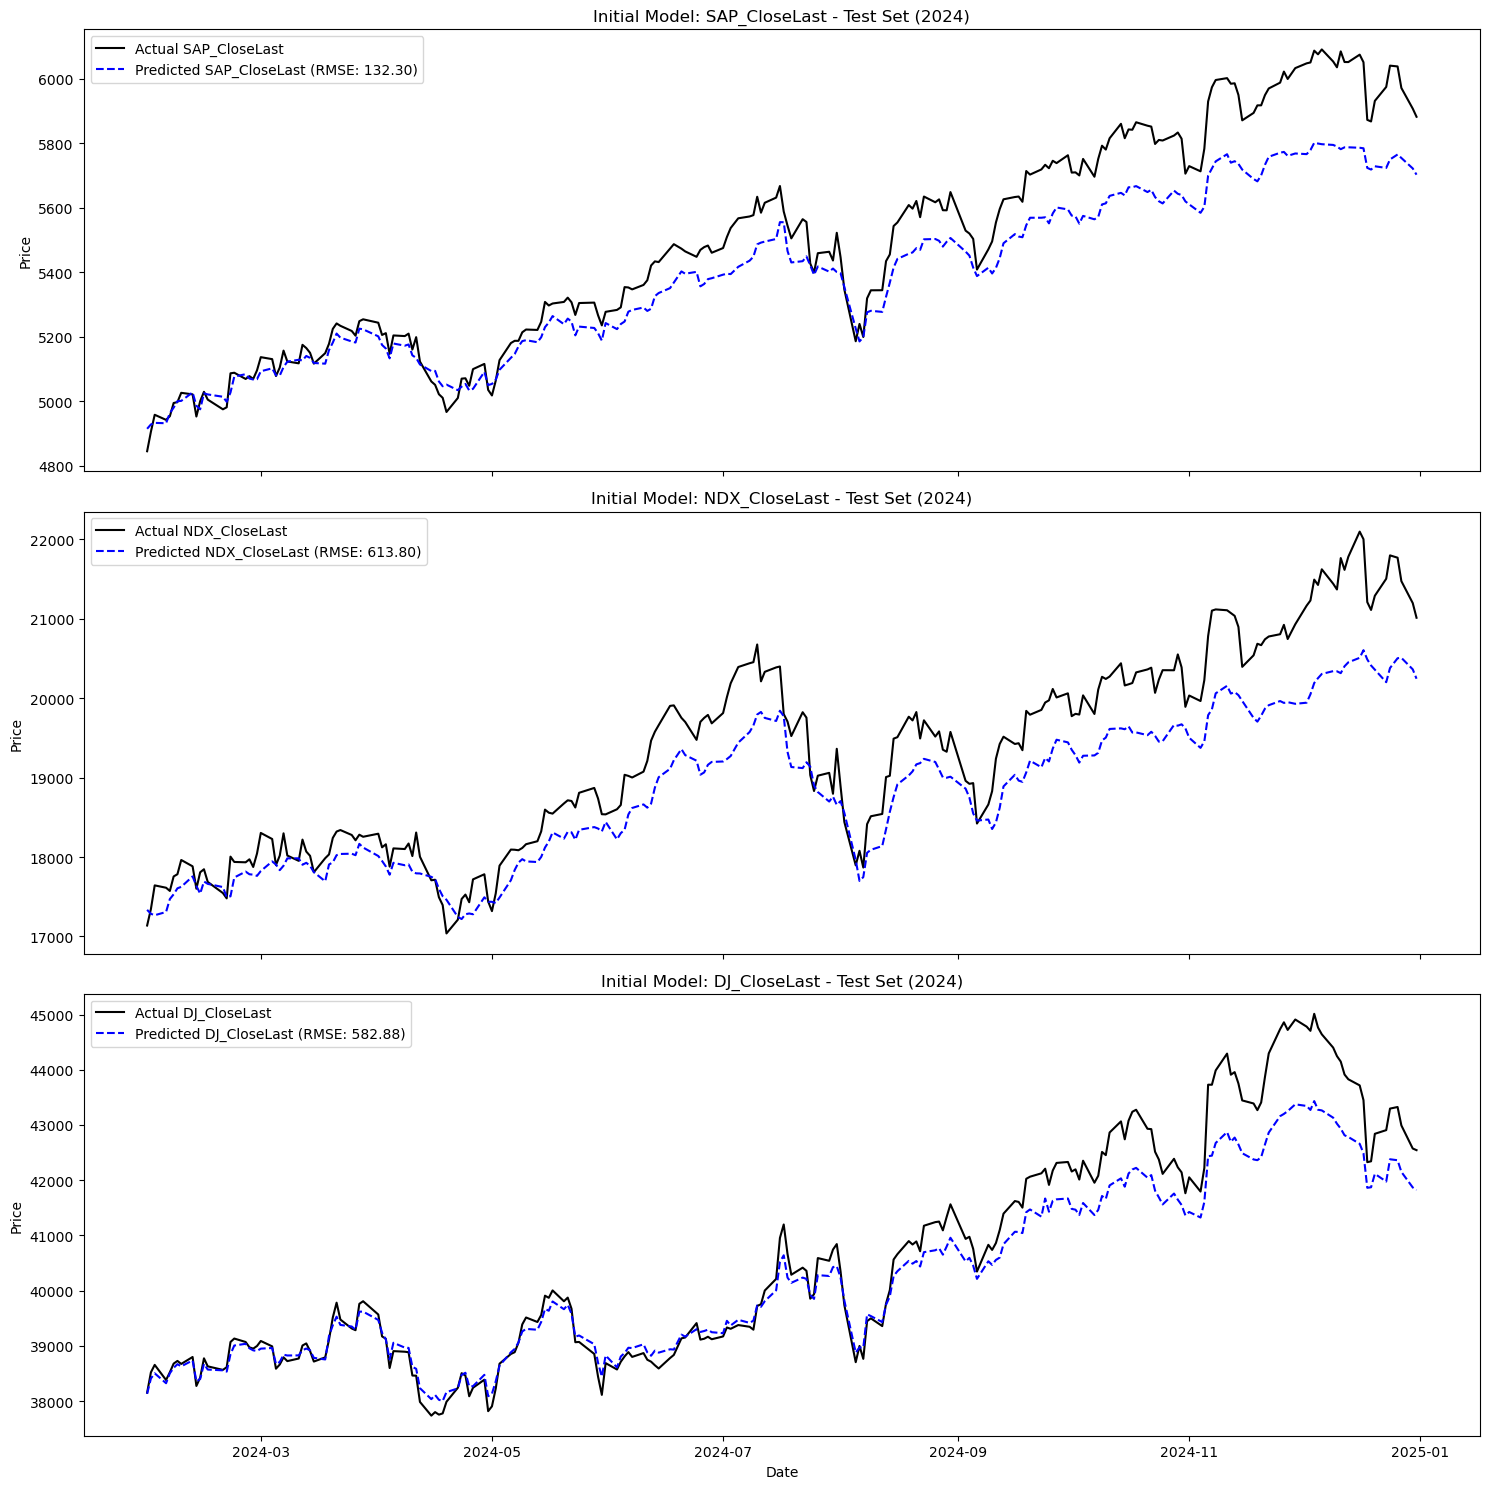

In [4]:
# Convert to tensors - Initial training and testing (2019-2023 train, 2024 test)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

#model training (initial)
input_size = X_train.shape[2] # Number of features
# Hyperparameters for this run (can be optimized later)
H_initial = 64 
L_initial = 2
LR_initial = 0.001

model_initial = StockGRU3(input_size, H_initial, L_initial, output_size=len(target_cols))
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_initial.parameters(), lr=LR_initial)

for epoch in range(N_EPOCHS):
    model_initial.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model_initial(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 5 == 0:
        print(f'Initial Model: Epoch [{epoch+1}/{N_EPOCHS}], Loss: {loss.item():.4f}')

# Evaluate on 2024 test set
model_initial.eval()
test_predictions_scaled = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        output = model_initial(X_batch)
        test_predictions_scaled.extend(output.numpy())
test_predictions_scaled = np.array(test_predictions_scaled)

# Inverse transform predictions and actuals for 2024 test set
dummy_preds_test = np.zeros((len(test_predictions_scaled), len(features_for_scaling)))
dummy_preds_test[:, target_indices_in_scaled_data] = test_predictions_scaled
test_predictions_inversed = scaler.inverse_transform(dummy_preds_test)[:, target_indices_in_scaled_data]

dummy_actuals_test = np.zeros((len(y_test), len(features_for_scaling)))
dummy_actuals_test[:, target_indices_in_scaled_data] = y_test
y_test_inversed = scaler.inverse_transform(dummy_actuals_test)[:, target_indices_in_scaled_data]

test_rmse_per_target = []
for i in range(y_test_inversed.shape[1]):
    rmse = root_mean_squared_error(y_test_inversed[:, i], test_predictions_inversed[:, i])
    test_rmse_per_target.append(rmse)
    print(f'Initial Model - Test RMSE for {target_cols[i]} (2024): {rmse:.2f}')

# Plot initial test results (2024)
fig, axs = plt.subplots(len(target_cols), 1, figsize=(15, 5 * len(target_cols)), sharex=True)
if len(target_cols) == 1: axs = [axs] # Make iterable if only one target
for i, ax in enumerate(axs):
    ax.plot(dates_test_seq, y_test_inversed[:, i], label=f'Actual {target_cols[i]}', color='black')
    ax.plot(dates_test_seq, test_predictions_inversed[:, i], label=f'Predicted {target_cols[i]} (RMSE: {test_rmse_per_target[i]:.2f})', color='blue', linestyle='--')
    ax.set_title(f'Initial Model: {target_cols[i]} - Test Set (2024)')
    ax.legend()
    ax.set_ylabel('Price')
plt.xlabel('Date')
plt.tight_layout()
plt.show()

## Hyperparameter Tuning & Final Validation (2025)

In [5]:
# Re-prep data for hyperparameter tuning and final validation
# Training on 2019-2024, Validating on 2025
# IMPORTANT: Use the SAME SCALER fitted on 2019-2023 data.
# Do NOT re-fit the scaler here.

trainval_idx_bool = (dates_processed.year >= 2019) & (dates_processed.year <= 2024)
final_val_idx_bool = dates_processed.year == 2025 # This was 'val_idx' in original, using 'final_val' for clarity

# Transform data using the *already fitted* scaler
scaled_trainval_data = scaler.transform(data_to_scale[trainval_idx_bool])
scaled_final_val_data = scaler.transform(data_to_scale[final_val_idx_bool])

# Create sequences
X_trainval, y_trainval = create_sequences_from_combined_array(scaled_trainval_data, SEQ_LEN, target_indices_in_scaled_data)
X_final_val, y_final_val = create_sequences_from_combined_array(scaled_final_val_data, SEQ_LEN, target_indices_in_scaled_data)

# Adjust dates for sequences
dates_trainval_seq = dates_processed[trainval_idx_bool][SEQ_LEN:]
dates_final_val_seq = dates_processed[final_val_idx_bool][SEQ_LEN:]

# Convert to tensors
X_trainval_tensor = torch.tensor(X_trainval, dtype=torch.float32)
y_trainval_tensor = torch.tensor(y_trainval, dtype=torch.float32)
X_final_val_tensor = torch.tensor(X_final_val, dtype=torch.float32)
y_final_val_tensor = torch.tensor(y_final_val, dtype=torch.float32)

trainval_dataset = TensorDataset(X_trainval_tensor, y_trainval_tensor)
trainval_loader = DataLoader(trainval_dataset, batch_size=BATCH_SIZE, shuffle=True)

final_val_dataset = TensorDataset(X_final_val_tensor, y_final_val_tensor)
final_val_loader = DataLoader(final_val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [6]:
#Hyperparameter tuning loop (example)
param_grid = {
    'hidden_size': [32, 64, 128],
    'num_layers': [1, 2],
    'learning_rate': [0.001, 0.0005]
}
all_params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]

best_overall_val_rmse = float('inf')
best_params_overall = None
best_model_state_overall = None
results_log = []

input_size_val = X_trainval.shape[2]

for params in all_params:
    H, L, LR = params['hidden_size'], params['num_layers'], params['learning_rate']
    print(f"Tuning with H={H}, L={L}, LR={LR}")
    
    current_model = StockGRU3(input_size_val, H, L, output_size=len(target_cols))
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(current_model.parameters(), lr=LR)
    
    for epoch in range(N_EPOCHS): # Use fewer epochs for tuning if desired, e.g., N_EPOCHS // 2
        current_model.train()
        for X_batch, y_batch in trainval_loader:
            optimizer.zero_grad()
            output = current_model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
    
    # Evaluate on the final validation set (2025)
    current_model.eval()
    current_val_predictions_scaled = []
    with torch.no_grad():
        for X_batch, y_batch in final_val_loader:
            output = current_model(X_batch)
            current_val_predictions_scaled.extend(output.numpy())
    current_val_predictions_scaled = np.array(current_val_predictions_scaled)
    
    # Inverse transform predictions and actuals for this validation run
    dummy_preds_val = np.zeros((len(current_val_predictions_scaled), len(features_for_scaling)))
    dummy_preds_val[:, target_indices_in_scaled_data] = current_val_predictions_scaled
    current_val_predictions_inversed = scaler.inverse_transform(dummy_preds_val)[:, target_indices_in_scaled_data]
    
    # y_final_val is already defined from sequence creation from scaled_final_val_data
    dummy_actuals_final_val = np.zeros((len(y_final_val), len(features_for_scaling)))
    dummy_actuals_final_val[:, target_indices_in_scaled_data] = y_final_val # y_final_val is already scaled target values
    y_final_val_inversed = scaler.inverse_transform(dummy_actuals_final_val)[:, target_indices_in_scaled_data]
    
    current_rmses = [root_mean_squared_error(y_final_val_inversed[:, i], current_val_predictions_inversed[:, i]) for i in range(y_final_val_inversed.shape[1])]
    avg_rmse = np.mean(current_rmses)
    print(f"Validation RMSEs for H={H}, L={L}, LR={LR}: {current_rmses}, Avg: {avg_rmse:.2f}")
    results_log.append({'params': params, 'avg_rmse': avg_rmse, 'rmses': current_rmses})
    
    if avg_rmse < best_overall_val_rmse:
        best_overall_val_rmse = avg_rmse
        best_params_overall = params
        best_model_state_overall = current_model.state_dict()

print(f"\nBest Overall Validation RMSE: {best_overall_val_rmse:.2f}")
print(f"Best Parameters: {best_params_overall}")

# Load the best model
best_model = StockGRU3(input_size_val, 
                       best_params_overall['hidden_size'], 
                       best_params_overall['num_layers'], 
                       output_size=len(target_cols))
best_model.load_state_dict(best_model_state_overall)


Tuning with H=32, L=1, LR=0.001
Validation RMSEs for H=32, L=1, LR=0.001: [88.52940760205672, 401.6408861633819, 409.7114775175821], Avg: 299.96
Tuning with H=32, L=1, LR=0.0005
Validation RMSEs for H=32, L=1, LR=0.0005: [83.26831476044046, 394.0825866123304, 650.5546947121387], Avg: 375.97
Tuning with H=32, L=2, LR=0.001
Validation RMSEs for H=32, L=2, LR=0.001: [93.39067194082739, 447.11467405371275, 449.674760108858], Avg: 330.06
Tuning with H=32, L=2, LR=0.0005
Validation RMSEs for H=32, L=2, LR=0.0005: [130.4924149889908, 545.8388098535247, 708.1365680623986], Avg: 461.49
Tuning with H=64, L=1, LR=0.001
Validation RMSEs for H=64, L=1, LR=0.001: [95.66030230294146, 338.7368850827299, 441.65690697205247], Avg: 292.02
Tuning with H=64, L=1, LR=0.0005
Validation RMSEs for H=64, L=1, LR=0.0005: [91.11705170716593, 405.16978440841524, 599.9149868726327], Avg: 365.40
Tuning with H=64, L=2, LR=0.001
Validation RMSEs for H=64, L=2, LR=0.001: [70.2688547582672, 297.907290387908, 409.3492733

<All keys matched successfully>

Best Model - Final Validation RMSE for SAP_CloseLast (2025): 43.89
Best Model - Final Validation RMSE for NDX_CloseLast (2025): 268.21
Best Model - Final Validation RMSE for DJ_CloseLast (2025): 198.92


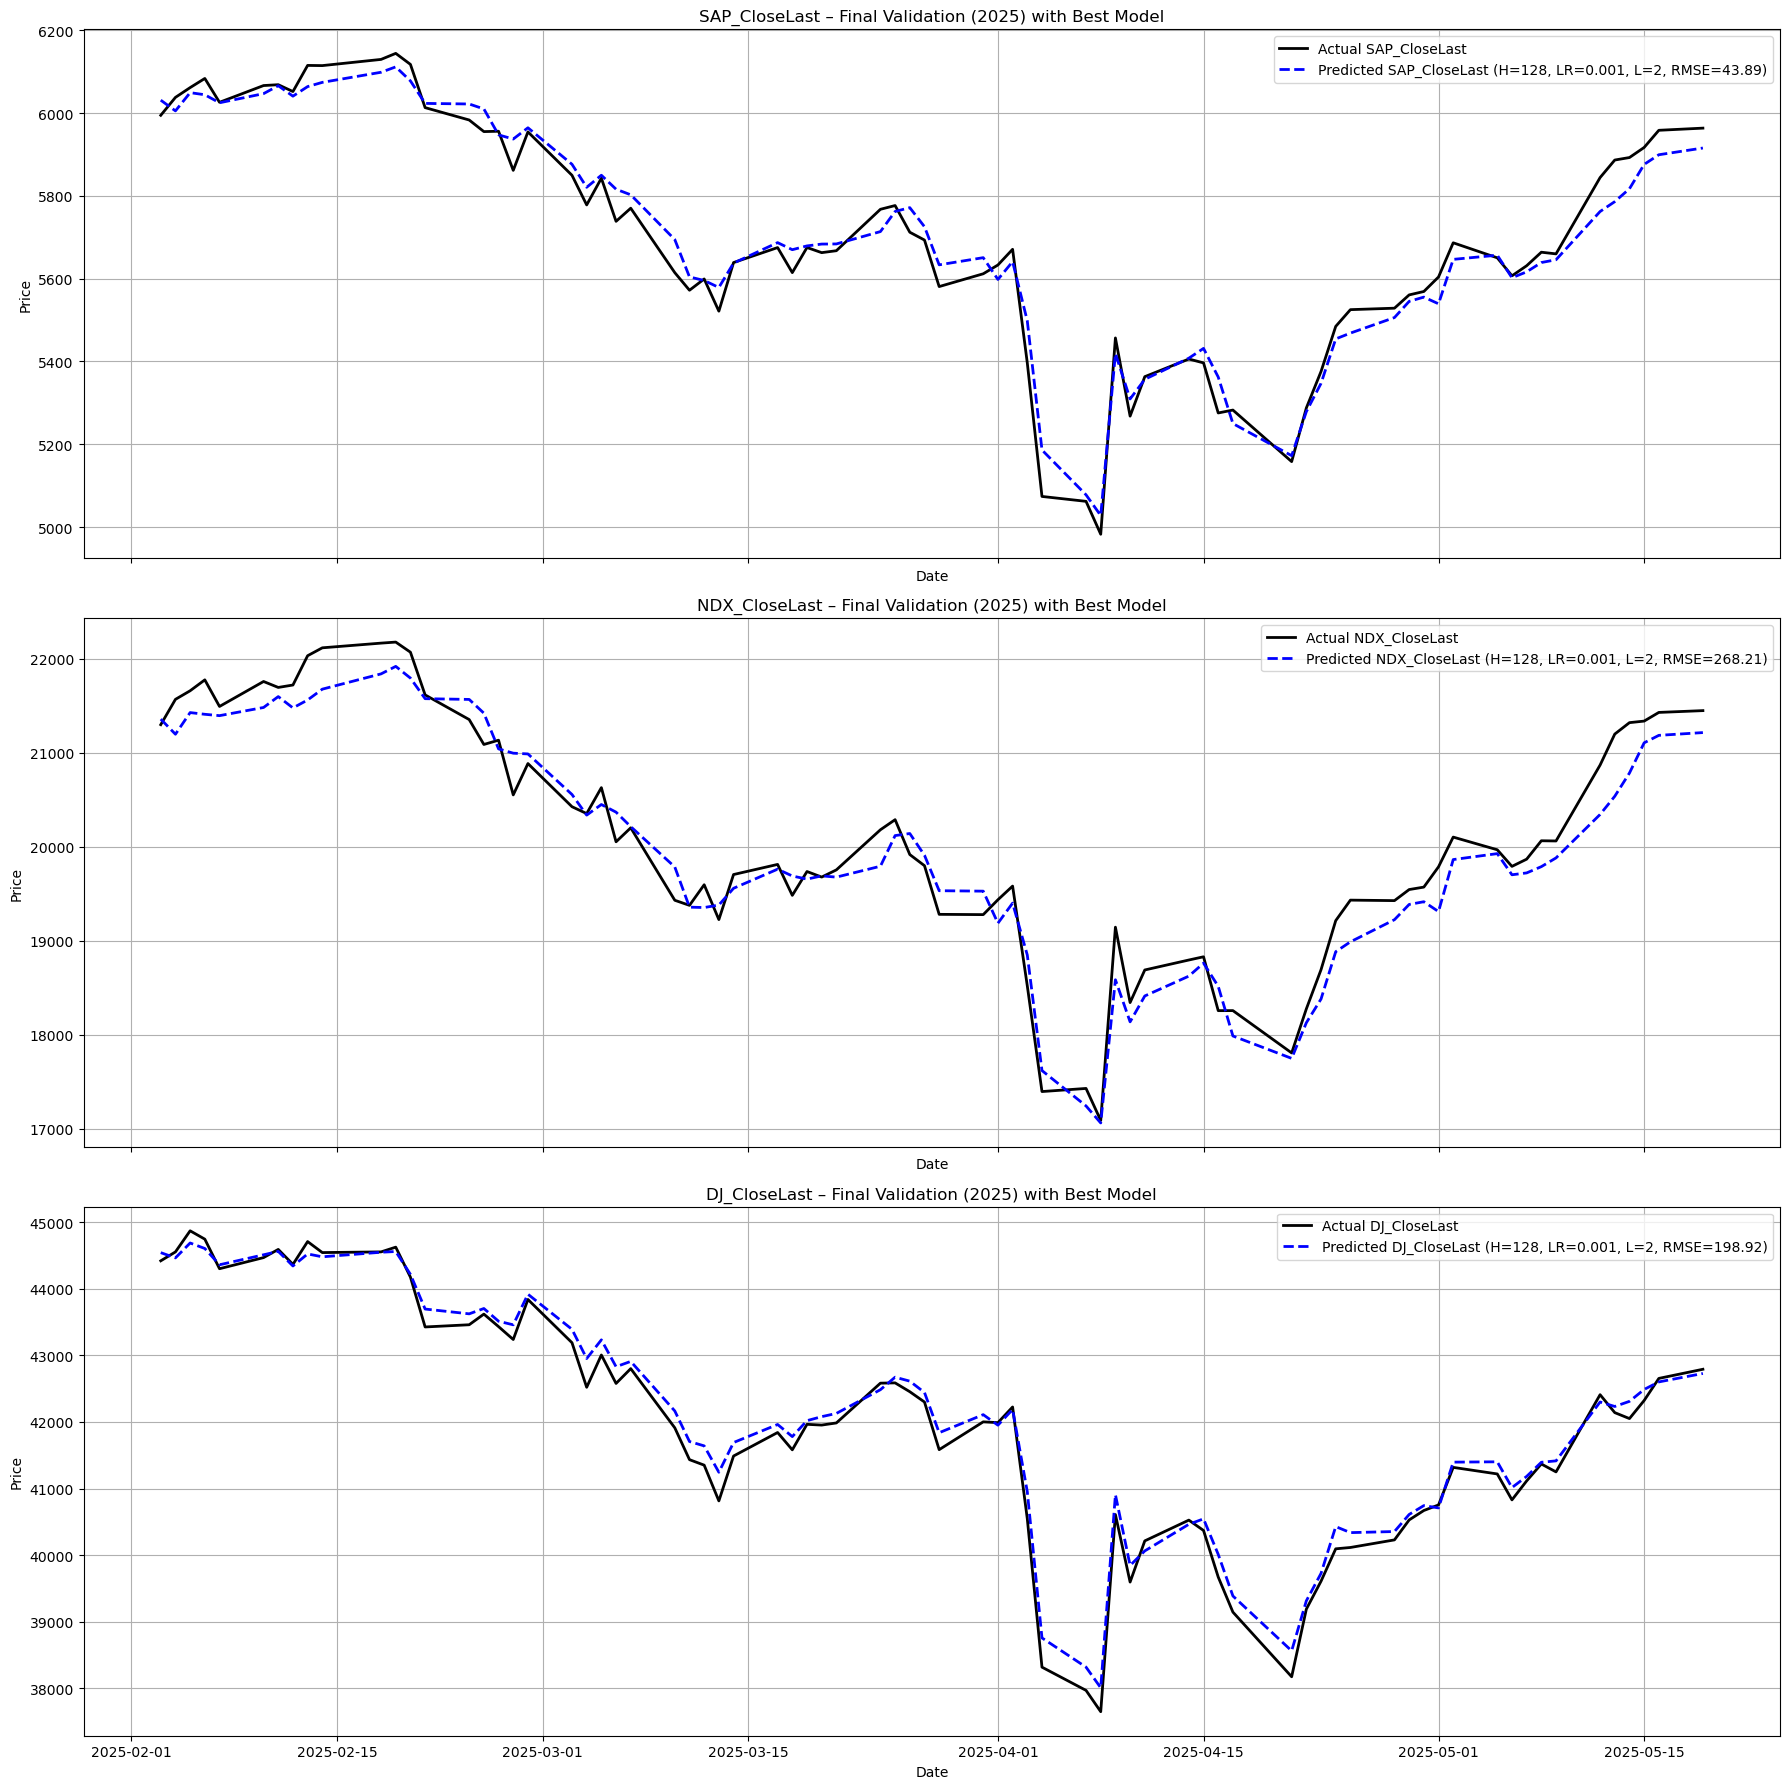

In [7]:
# Final Evaluation and Plotting with the Best Model on Validation Set (2025)
best_model.eval()
final_predictions_scaled = []
with torch.no_grad():
    for X_batch, y_batch in final_val_loader: # Using final_val_loader
        output = best_model(X_batch)
        final_predictions_scaled.extend(output.numpy())
final_predictions_scaled = np.array(final_predictions_scaled)

# Inverse transform
dummy_final_preds = np.zeros((len(final_predictions_scaled), len(features_for_scaling)))
dummy_final_preds[:, target_indices_in_scaled_data] = final_predictions_scaled
final_predictions_inversed = scaler.inverse_transform(dummy_final_preds)[:, target_indices_in_scaled_data]

# y_final_val_inversed was already computed during tuning, or recompute for safety:
dummy_actuals_final_val = np.zeros((len(y_final_val), len(features_for_scaling)))
dummy_actuals_final_val[:, target_indices_in_scaled_data] = y_final_val
y_final_val_inversed_for_plot = scaler.inverse_transform(dummy_actuals_final_val)[:, target_indices_in_scaled_data]

final_val_rmses = []
for i in range(y_final_val_inversed_for_plot.shape[1]):
    rmse = root_mean_squared_error(y_final_val_inversed_for_plot[:, i], final_predictions_inversed[:, i])
    final_val_rmses.append(rmse)
    print(f'Best Model - Final Validation RMSE for {target_cols[i]} (2025): {rmse:.2f}')

H_best = best_params_overall['hidden_size']
LR_best = best_params_overall['learning_rate']
L_best = best_params_overall['num_layers']

# Plot final validation results
fig, axs = plt.subplots(len(target_cols), 1, figsize=(18, 6 * len(target_cols)), sharex=True)
if len(target_cols) == 1: axs = [axs] # Make iterable if only one target

for i, ax in enumerate(axs):
    feature_name = target_cols[i]
    rmse_val = final_val_rmses[i]
    legend_label = f"Predicted {feature_name} (H={H_best}, LR={LR_best}, L={L_best}, RMSE={rmse_val:.2f})"
    
    ax.plot(dates_final_val_seq, y_final_val_inversed_for_plot[:, i],
            label=f"Actual {feature_name}", color="black", linewidth=2)
    ax.plot(dates_final_val_seq, final_predictions_inversed[:, i],
            label=legend_label, color="blue", linewidth=2, linestyle='--')
    ax.set_title(f"{feature_name} – Final Validation (2025) with Best Model")
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()